 # TLT FasterRCNN example usecase

 This notebook shows an example usecase of FasterRCNN using Transfer Learning Toolkit.

 0. [Set up env variables](#head-0)
 1. [Prepare dataset and pretrained model](#head-1)<br>
     1.1 [Prepare tfrecords from kitti format dataset](#head-1-1)<br>
     1.2 [Download pretrained model](#head-1-2)
 2. [Provide training specification](#head-2)
 3. [Run TLT training](#head-3)
 4. [Evaluate trained models](#head-4)
 5. [Prune trained models](#head-5)
 6. [Retrain pruned models](#head-6)
 7. [Evaluate retrained model](#head-7)
 8. [Visualize inferences](#head-8)
 9. [Deploy](#head-9)
 10. [QAT workflow](#head-10)<br>
     10.1 [Training](#head-10.1)<br>
     10.2 [Evaluation](#head-10.2)<br>
     10.3 [Pruning](#head-10.3)<br>
     10.4 [Retraining](#head-10.4)<br>
     10.5 [Evaluation of the retrained model](#head-10.5)<br>
     10.6 [Inference of the retrained model](#head-10.6)<br>
     10.7 [Deployment of the QAT model](#head-10.7)

 ## 0. Set up env variables <a class="anchor" id="head-0"></a>

In [1]:
# Setting up env variables for cleaner command line commands.
print("Please replace the variables with your own.")
%env GPU_INDEX=0
%env KEY=tlt
%env USER_EXPERIMENT_DIR=/workspace/tlt-experiments/insect-thesis
%env DATA_DOWNLOAD_DIR=/workspace/tlt-experiments/insect-thesis/data
%env SPECS_DIR=./specs
!mkdir -p $DATA_DOWNLOAD_DIR/faster_rcnn
# Prepend current directory and HOME directory to the PATH env variable.
import os
os.environ['PATH'] = './:' + os.environ.get('HOME', '') + ':' + os.environ['PATH']

Please replace the variables with your own.
env: GPU_INDEX=0
env: KEY=tlt
env: USER_EXPERIMENT_DIR=/workspace/tlt-experiments/insect-thesis
env: DATA_DOWNLOAD_DIR=/workspace/tlt-experiments/insect-thesis/data
env: SPECS_DIR=./specs


 ## 1. Prepare dataset and pretrained model <a class="anchor" id="head-1"></a>

 We will be using the KITTI detection dataset for the tutorial. To find more details please visit
 http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=2d. Please download the KITTI detection images (http://www.cvlibs.net/download.php?file=data_object_image_2.zip) and labels (http://www.cvlibs.net/download.php?file=data_object_label_2.zip) to $DATA_DOWNLOAD_DIR.

In [2]:
# Check the dataset is present
#!mkdir -p $DATA_DOWNLOAD_DIR
#!if [ ! -f $DATA_DOWNLOAD_DIR/data_object_image_2.zip ]; then echo 'Image zip file not found, please download.'; else echo 'Found Image zip file.';fi
#!if [ ! -f $DATA_DOWNLOAD_DIR/data_object_label_2.zip ]; then echo 'Label zip file not found, please download.'; else echo 'Found Labels zip file.';fi

In [3]:
# unpack 
#!unzip -u $DATA_DOWNLOAD_DIR/data_object_image_2.zip -d $DATA_DOWNLOAD_DIR
#!unzip -u $DATA_DOWNLOAD_DIR/data_object_label_2.zip -d $DATA_DOWNLOAD_DIR

In [28]:
# verify
!ls -l $DATA_DOWNLOAD_DIR/kitti

total 40
drwxr-xr-x 6 1000 1000 4096 Mar 24 16:21 augmented_dataset
-rw-rw-r-- 1 1000 1000 1157 Mar 24 08:54 correct-kitti.py
drwxrwxr-x 5 1000 1000 4096 Mar 26 16:04 fusion
drwxrwxr-x 4 1000 1000 4096 Mar 26 10:42 geometridae
drwxr-xr-x 6 1000 1000 4096 Mar 26 13:55 geometridae_augmented
drwxrwxrwx 7 1000 1000 4096 Mar 23 23:15 noctuidae
drwxr-xr-x 3 1000 1000 4096 Mar 26 17:31 noctuidae_augmented
drwxrwxr-x 4 1000 1000 4096 Mar 26 14:38 nymphalidae
-rwxrwxrwx 1 1000 1000 1617 Mar 26 10:45 organize.py
-rwxrwxrwx 1 1000 1000  864 Mar 26 10:46 transfer.py


Additionally, if you have your own dataset already in a volume (or folder), you can mount the volume on `DATA_DOWNLOAD_DIR` (or create a soft link). Below shows an example:
```bash
# if your dataset is in /dev/sdc1
mount /dev/sdc1 $DATA_DOWNLOAD_DIR

# if your dataset is in folder /var/dataset
ln -sf /var/dataset $DATA_DOWNLOAD_DIR
```

### 1.1 Prepare tfrecords from kitti format dataset <a class="anchor" id="head-1-1"></a>

* Update the tfrecords spec file to take in your kitti format dataset
* Create the tfrecords using the dataset_convert 
* TFRecords only need to be generated once.

In [31]:
print("TFrecords conversion spec file for training")
!cat $SPECS_DIR/frcnn_tfrecords_kitti_trainval_custom.txt

TFrecords conversion spec file for training
kitti_config {
  root_directory_path: "/workspace/tlt-experiments/insect-thesis/data/kitti/fusion/train"
  image_dir_name: "images"
  label_dir_name: "labels"
  image_extension: ".jpg"
  partition_mode: "random"
  num_partitions: 2
  val_split: 14
  num_shards: 10
}
image_directory_path: "/workspace/tlt-experiments/insect-thesis/data/kitti/fusion/train"


In [33]:
# Creating a new directory for the output tfrecords dump.
!mkdir -p $USER_EXPERIMENT_DIR/tfrecords
#KITTI trainval
!faster_rcnn dataset_convert --gpu_index $GPU_INDEX -d $SPECS_DIR/frcnn_tfrecords_kitti_trainval_custom.txt \
                     -o $USER_EXPERIMENT_DIR/data/kitti/fusion/tfrecords/kitti_trainval/kitti_trainval

Using TensorFlow backend.
Using TensorFlow backend.
2021-03-26 17:40:21,596 - iva.detectnet_v2.dataio.build_converter - INFO - Instantiating a kitti converter
2021-03-26 17:40:21,610 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Num images in
Train: 5818	Val: 946
2021-03-26 17:40:21,610 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Validation data in partition 0. Hence, while choosing the validationset during training choose validation_fold 0.
2021-03-26 17:40:21,614 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Writing partition 0, shard 0

2021-03-26 17:40:21,614 - tensorflow - WARNING - From /home/vpraveen/.cache/dazel/_dazel_vpraveen/216c8b41e526c3295d3b802489ac2034/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/detectnet_v2/dataio/dataset_converter_lib.py:142: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

/usr/local/lib/python3.6/dist-packages/iva/detect

In [34]:
!ls -rlt $USER_EXPERIMENT_DIR/data/kitti/fusion/tfrecords/kitti_trainval

total 4128
-rw-r--r-- 1 root root  57937 Mar 26 17:40 kitti_trainval-fold-000-of-002-shard-00000-of-00010
-rw-r--r-- 1 root root  57928 Mar 26 17:40 kitti_trainval-fold-000-of-002-shard-00001-of-00010
-rw-r--r-- 1 root root  57948 Mar 26 17:40 kitti_trainval-fold-000-of-002-shard-00002-of-00010
-rw-r--r-- 1 root root  57871 Mar 26 17:40 kitti_trainval-fold-000-of-002-shard-00003-of-00010
-rw-r--r-- 1 root root  57891 Mar 26 17:40 kitti_trainval-fold-000-of-002-shard-00004-of-00010
-rw-r--r-- 1 root root  57911 Mar 26 17:40 kitti_trainval-fold-000-of-002-shard-00005-of-00010
-rw-r--r-- 1 root root  57990 Mar 26 17:40 kitti_trainval-fold-000-of-002-shard-00006-of-00010
-rw-r--r-- 1 root root  57965 Mar 26 17:40 kitti_trainval-fold-000-of-002-shard-00007-of-00010
-rw-r--r-- 1 root root  57871 Mar 26 17:40 kitti_trainval-fold-000-of-002-shard-00008-of-00010
-rw-r--r-- 1 root root  61576 Mar 26 17:40 kitti_trainval-fold-000-of-002-shard-00009-of-00010
-rw-r--r-- 1 root root 358241 Mar 26 17

 ### 1.2 Download pre-trained model <a class="anchor" id="head-1-2"></a>

In [7]:
!ngc registry model list nvidia/tlt_pretrained_object_detection*

+---------+---------+---------+---------+---------+---------+---------+---------+
| Name    | Reposit | Latest  | Applica | Framewo | Precisi | Last Mo | Permiss |
|         | ory     | Version | tion    | rk      | on      | dified  | ion     |
+---------+---------+---------+---------+---------+---------+---------+---------+
| TLT Pre | nvidia/ | cspdark | Object  | Transfe | FP32    | Feb 25, | unlocke |
| trained | tlt_pre | net19   | Detecti | r Learn |         | 2021    | d       |
| Object  | trained |         | on      | ing     |         |         |         |
| Detecti | _object |         |         | Toolkit |         |         |         |
| on      | _detect |         |         |         |         |         |         |
|         | ion     |         |         |         |         |         |         |
+---------+---------+---------+---------+---------+---------+---------+---------+


In [7]:
# Download model from NGC.
!ngc registry model download-version nvidia/tlt_pretrained_object_detection:resnet18

^C


In [6]:
!ls tlt_pretrained_object_detection_vdarknet19

ls: cannot access 'tlt_pretrained_object_detection_vdarknet19': No such file or directory


In [8]:
# Copy weights to data directory.
#!cp tlt_pretrained_object_detection_vresnet18/resnet_18.hdf5 $DATA_DOWNLOAD_DIR/faster_rcnn/
!cp tlt_pretrained_object_detection_vdarknet19/darknet_19.hdf5 $DATA_DOWNLOAD_DIR/faster_rcnn/
!rm -rf tlt_pretrained_object_detection_vdarknet19
!ls -rlt $DATA_DOWNLOAD_DIR/faster_rcnn

cp: cannot stat 'tlt_pretrained_object_detection_vdarknet19/darknet_19.hdf5': No such file or directory
total 247584
-rwxrwxrwx 1 root root  93278448 Mar 20 13:11 resnet_18.hdf5
-rwxrwxrwx 1 root root 160242408 Mar 21 13:58 darknet_19.hdf5


 ## 2. Provide training specification <a class="anchor" id="head-2"></a>

In [2]:
!sed -i 's/$KEY/'"$KEY/g" $SPECS_DIR/default_spec_resnet18_custom.txt
!cat $SPECS_DIR/default_spec_resnet18_custom.txt

# Copyright (c) 2017-2020, NVIDIA CORPORATION.  All rights reserved.
random_seed: 42
enc_key: 'tlt'
verbose: True
model_config {
input_image_config {
image_type: RGB
image_channel_order: 'bgr'
size_height_width {
height: 400
width: 400
}
    image_channel_mean {
        key: 'b'
        value: 103.939
}
    image_channel_mean {
        key: 'g'
        value: 116.779
}
    image_channel_mean {
        key: 'r'
        value: 123.68
}
image_scaling_factor: 1.0
max_objects_num_per_image: 100
}
arch: "resnet:18"
anchor_box_config {
scale: 64.0
scale: 128.0
scale: 256.0
ratio: 1.0
ratio: 0.5
ratio: 2.0
}
freeze_bn: True
freeze_blocks: 0
freeze_blocks: 1
roi_mini_batch: 256
rpn_stride: 16
use_bias: False
roi_pooling_config {
pool_size: 7
pool_size_2x: False
}
all_projections: True
use_pooling:False
}
dataset_config {
  data_sources: {
    tfrecords_path: "/workspace/tlt-experiments/insect-thesis/data/kitti/fusion/tfrecords/kitti_trainval/kitti_trainval*"
    image_directory_path: "/workspac

 ## 3. Run TLT training <a class="anchor" id="head-3"></a>
 * Provide the sample spec file for training.

In [ ]:
# add the faster_rcnn folder inside the dataset folder first ! 

In [4]:
!faster_rcnn train --gpu_index  $GPU_INDEX --use_amp -e $SPECS_DIR/default_spec_resnet18_custom.txt

Using TensorFlow backend.
Using TensorFlow backend.

2021-03-27 10:31:48,556 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/horovod/tensorflow/__init__.py:117: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.


2021-03-27 10:31:48,556 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/horovod/tensorflow/__init__.py:143: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.


2021-03-27 10:31:48,672 [WARNING] tensorflow: From /home/vpraveen/.cache/dazel/_dazel_vpraveen/216c8b41e526c3295d3b802489ac2034/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/faster_rcnn/scripts/train.py:47: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


2021-03-27 10:31:48,673 [WARNING] tensorflow: From /home/vpraveen/.cache/dazel/_dazel_vpraveen/216c8b41e526c3295d3b802489ac2034/execroot/ai_infra/bazel-out


2021-03-27 10:31:53,249 [WARNING] tensorflow: From /home/vpraveen/.cache/dazel/_dazel_vpraveen/216c8b41e526c3295d3b802489ac2034/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/faster_rcnn/layers/utils.py:76: The name tf.debugging.assert_less is deprecated. Please use tf.compat.v1.debugging.assert_less instead.


2021-03-27 10:31:53,421 [WARNING] tensorflow: From /home/vpraveen/.cache/dazel/_dazel_vpraveen/216c8b41e526c3295d3b802489ac2034/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/faster_rcnn/layers/utils.py:382: The name tf.random_shuffle is deprecated. Please use tf.random.shuffle instead.


2021-03-27 10:31:53,649 [WARNING] tensorflow: From /home/vpraveen/.cache/dazel/_dazel_vpraveen/216c8b41e526c3295d3b802489ac2034/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/faster_rcnn/layers/utils.py:255: The name tf.log is deprecated. P


2021-03-27 10:32:00,831 [WARNING] tensorflow: From /home/vpraveen/.cache/dazel/_dazel_vpraveen/216c8b41e526c3295d3b802489ac2034/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/faster_rcnn/layers/utils.py:64: The name tf.unsorted_segment_min is deprecated. Please use tf.math.unsorted_segment_min instead.

2021-03-27 10:32:01,566 [INFO] __main__: Building validation dataset...
2021-03-27 10:32:02,243 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Serial augmentation enabled = False
2021-03-27 10:32:02,243 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Pseudo sharding enabled = False
2021-03-27 10:32:02,244 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Max Image Dimensions (all sources): (0, 0)
2021-03-27 10:32:02,244 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: number of cpus: 12, io threads: 24, compute threads: 12, buffered batches: 4
2021-03-27 10:


2021-03-27 10:33:16,076 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.


2021-03-27 10:33:16,209 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

Epoch 1/20
   2/5818 [..............................] - ETA: 10:55:47 - loss: 3.4059 - rpn_out_class_loss: 0.7033 - rpn_out_regress_loss: 0.0057 - dense_class_td_loss: 2.0764 - dense_regress_td_loss: 0.1588 - dense_class_td_acc: 0.1699/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.716150). Check your callbacks.
  % delta_t_median)
5818/5818 [==============================] - 365s 63ms/step - loss: 0.7248 - rpn_out_class_loss: 0.0227 - rpn_out_regress_loss: 0.0120 - dense_class_td_lo

In [ ]:
print('Model for each epoch:')
print('---------------------')
!ls -lht $USER_EXPERIMENT_DIR/data/faster_rcnn

In [ ]:
print("For multi-GPU, please uncomment and run this instead. Change --gpus  and --gpu_index based on your machine.")
# !faster_rcnn train -e $SPECS_DIR/default_spec_resnet18.txt \
#                    --gpus 2 \
#                    --gpu_index 1 2

In [ ]:
print("For resume training from checkpoint, please uncomment and run this instead. Change/Add the 'resume_from_model' field in the spec file.")
# !faster_rcnn train --gpu_index $GPU_INDEX -e $SPECS_DIR/default_spec_resnet18.txt

In [ ]:
print("For Automatic Mixed Precision(AMP) training, please uncomment and run this. Make sure you use the Volta or above GPU arch to enable AMP.")
# !faster_rcnn train --gpu_index $GPU_INDEX --use_amp -e $SPECS_DIR/default_spec_resnet18.txt

 ## 4. Evaluate trained models <a class="anchor" id="head-4"></a>

In [40]:
!faster_rcnn evaluate --gpu_index $GPU_INDEX -e $SPECS_DIR/default_spec_resnet18_custom.txt

Using TensorFlow backend.
Using TensorFlow backend.
2021-03-26 20:15:41,916 [INFO] iva.faster_rcnn.spec_loader.spec_loader: Loading experiment spec at ./specs/default_spec_resnet18_custom.txt.

2021-03-26 20:15:41,932 [WARNING] tensorflow: From /home/vpraveen/.cache/dazel/_dazel_vpraveen/216c8b41e526c3295d3b802489ac2034/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/faster_rcnn/scripts/evaluate.py:60: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


2021-03-26 20:15:41,932 [WARNING] tensorflow: From /home/vpraveen/.cache/dazel/_dazel_vpraveen/216c8b41e526c3295d3b802489ac2034/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/faster_rcnn/scripts/evaluate.py:62: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.


2021-03-26 20:15:42,180 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_b


2021-03-26 20:15:44,333 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.

2021-03-26 20:15:44,622 [INFO] __main__: Building evaluation model, may take a while...

2021-03-26 20:16:04,327 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.


2021-03-26 20:16:04,372 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp

2021-03-26 20:16:06,029 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Serial augmentation enabled = False
2021-03-26 20:16:06,029 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Pseudo sharding enabled = False
2021-03-26 20:16:06,029 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Max Image Dimensions (all sources): (0, 0)
2021-03-26 20:16:06,029 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: number of cpus: 12, io threads: 24, compute threads: 12, buffered batches: 4
2021-03-26 20:16:06,029 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: total dataset size 946, number of sources: 1, batch size per gpu: 1, steps: 946
2021-03-26 20:16:06,089 [WARNING] tensorflow: Entity <bound method DriveNetTFRecordsParser.__call__ of <iva.detectnet_v2.dataloader.drivenet_dataloader.DriveNetTFRecordsParser object at 0x7f8c847770b8>> could not be transformed and will be executed as-is. Please report th

 ## 5. Prune trained models <a class="anchor" id="head-5"></a>
 * Specify pre-trained model
 * Equalization criterion
 * Threshold for pruning
 * A key to save and load the model
 * Output directory to store the model
 
Usually, you just need to adjust `-pth` (threshold) for accuracy and model size trade off. Higher `pth` gives you smaller model (and thus higher inference speed) but worse accuracy. The threshold to use is depend on the dataset. A `pth` value below is just a start point. If the retrain accuracy is good, you can increase this value to get smaller models. Otherwise, lower this value to get better accuracy.

In [6]:
!faster_rcnn prune --gpu_index $GPU_INDEX -m $USER_EXPERIMENT_DIR/data/kitti/fusion/faster_rcnn/frcnn_kitti_resnet18.epoch20.tlt \
           -o $USER_EXPERIMENT_DIR/data/kitti/fusion/faster_rcnn/model_1_pruned.tlt  \
           -eq union  \
           -pth 0.2 \
           -k $KEY

Using TensorFlow backend.
Using TensorFlow backend.
2021-03-27 11:07:53,112 [INFO] modulus.pruning.pruning: Exploring graph for retainable indices
2021-03-27 11:07:54,061 [INFO] modulus.pruning.pruning: Pruning model and appending pruned nodes to new graph
2021-03-27 11:08:17,702 [INFO] iva.common.magnet_prune: Pruning ratio (pruned model / original model): 0.4400066753705803


In [53]:
!ls -lht $USER_EXPERIMENT_DIR/data/kitti/fusion/faster_rcnn

total 2.0G
-rw-r--r-- 1 root root 49M Mar 26 22:18 model_1_pruned.tlt
-rw-r--r-- 1 root root 97M Mar 26 20:15 frcnn_kitti_resnet18.epoch20.tlt
-rw-r--r-- 1 root root 97M Mar 26 20:07 frcnn_kitti_resnet18.epoch19.tlt
-rw-r--r-- 1 root root 97M Mar 26 20:00 frcnn_kitti_resnet18.epoch18.tlt
-rw-r--r-- 1 root root 97M Mar 26 19:52 frcnn_kitti_resnet18.epoch17.tlt
-rw-r--r-- 1 root root 97M Mar 26 19:44 frcnn_kitti_resnet18.epoch16.tlt
-rw-r--r-- 1 root root 97M Mar 26 19:36 frcnn_kitti_resnet18.epoch15.tlt
-rw-r--r-- 1 root root 97M Mar 26 19:29 frcnn_kitti_resnet18.epoch14.tlt
-rw-r--r-- 1 root root 97M Mar 26 19:21 frcnn_kitti_resnet18.epoch13.tlt
-rw-r--r-- 1 root root 97M Mar 26 19:14 frcnn_kitti_resnet18.epoch12.tlt
-rw-r--r-- 1 root root 97M Mar 26 19:06 frcnn_kitti_resnet18.epoch11.tlt
-rw-r--r-- 1 root root 97M Mar 26 18:59 frcnn_kitti_resnet18.epoch10.tlt
-rw-r--r-- 1 root root 97M Mar 26 18:51 frcnn_kitti_resnet18.epoch9.tlt
-rw-r--r-- 1 root root 97M Mar 26 18:44 frcnn_kitti_res

 ## 6. Retrain pruned models <a class="anchor" id="head-6"></a>
 * Model needs to be re-trained to bring back accuracy after pruning
 * Specify re-training specification

In [7]:
# Here we have updated the spec file to include the newly pruned model as a pretrained weights.
!sed -i 's/$KEY/'"$KEY/g" $SPECS_DIR/default_spec_resnet18_retrain_spec_custom.txt
!cat $SPECS_DIR/default_spec_resnet18_retrain_spec_custom.txt

# Copyright (c) 2017-2020, NVIDIA CORPORATION.  All rights reserved.
random_seed: 42
enc_key: 'tlt'
verbose: True
model_config {
input_image_config {
image_type: RGB
image_channel_order: 'bgr'
size_height_width {
height: 400
width: 400
}
    image_channel_mean {
        key: 'b'
        value: 103.939
}
    image_channel_mean {
        key: 'g'
        value: 116.779
}
    image_channel_mean {
        key: 'r'
        value: 123.68
}
image_scaling_factor: 1.0
max_objects_num_per_image: 100
}
arch: "resnet:18"
anchor_box_config {
scale: 64.0
scale: 128.0
scale: 256.0
ratio: 1.0
ratio: 0.5
ratio: 2.0
}
freeze_bn: True
freeze_blocks: 0
freeze_blocks: 1
roi_mini_batch: 256
rpn_stride: 16
use_bias: False
roi_pooling_config {
pool_size: 7
pool_size_2x: False
}
all_projections: True
use_pooling:False
}
dataset_config {
  data_sources: {
    tfrecords_path: "/workspace/tlt-experiments/insect-thesis/data/kitti/fusion/tfrecords/kitti_trainval/kitti_trainval*"
    image_directory_path: "/workspac

In [8]:
# Retraining using the pruned model as pretrained weights 
!faster_rcnn train --gpu_index $GPU_INDEX --use_amp -e $SPECS_DIR/default_spec_resnet18_retrain_spec_custom.txt

Using TensorFlow backend.
Using TensorFlow backend.

2021-03-27 11:08:31,735 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/horovod/tensorflow/__init__.py:117: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.


2021-03-27 11:08:31,735 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/horovod/tensorflow/__init__.py:143: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.


2021-03-27 11:08:31,774 [WARNING] tensorflow: From /home/vpraveen/.cache/dazel/_dazel_vpraveen/216c8b41e526c3295d3b802489ac2034/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/faster_rcnn/scripts/train.py:47: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


2021-03-27 11:08:31,774 [WARNING] tensorflow: From /home/vpraveen/.cache/dazel/_dazel_vpraveen/216c8b41e526c3295d3b802489ac2034/execroot/ai_infra/bazel-out


2021-03-27 11:08:33,387 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.


2021-03-27 11:08:33,399 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.


2021-03-27 11:08:33,413 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.


2021-03-27 11:08:33,863 [WARNING] tensorflow: From /home/vpraveen/.cache/dazel/_dazel_vpraveen/216c8b41e526c3295d3b802489ac2034/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/faster_rcnn/layers/utils.py:76: The name tf.debugging.assert_less is deprecated. Please use tf.compat.v1.de

2021-03-27 11:09:50,974 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: shuffle: False - shard 0 of 1
2021-03-27 11:09:50,978 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: sampling 1 datasets with weights:
2021-03-27 11:09:50,979 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: source: 0 weight: 1.000000
2021-03-27 11:09:50,991 [WARNING] tensorflow: Entity <bound method Processor.__call__ of <modulus.blocks.data_loaders.multi_source_loader.processors.asset_loader.AssetLoader object at 0x7f15f00dba58>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Unable to locate the source code of <bound method Processor.__call__ of <modulus.blocks.data_loaders.multi_source_loader.processors.asset_loader.AssetLoader object at 0x7f15f00dba58>>. Note that functions defined 


2021-03-27 11:11:53,277 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.


2021-03-27 11:11:53,411 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

Epoch 1/20
   2/5818 [..............................] - ETA: 6:27:13 - loss: 0.1102 - rpn_out_class_loss: 0.0033 - rpn_out_regress_loss: 0.0015 - dense_class_td_loss: 0.0191 - dense_regress_td_loss: 0.0086 - dense_class_td_acc: 0.9961/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.104228). Check your callbacks.
  % delta_t_median)
5818/5818 [==============================] - 249s 43ms/step - loss: 0.1622 - rpn_out_class_loss: 0.0103 - rpn_out_regress_loss: 0.0033 - dense_class_td_los

5818/5818 [==============================] - 248s 43ms/step - loss: 0.1857 - rpn_out_class_loss: 0.0132 - rpn_out_regress_loss: 0.0046 - dense_class_td_loss: 0.0504 - dense_regress_td_loss: 0.0438 - dense_class_td_acc: 0.9796
Doing validation at epoch 12(1-based index)...
100%|█████████████████████████████████████████| 946/946 [00:17<00:00, 54.22it/s]
Class               AP                  precision           recall              RPN_recall          
------------------------------------------------------------------------------------------
geometridae         0.6475              0.0310              0.9027              0.9876              
------------------------------------------------------------------------------------------
noctuidae           0.9241              0.0574              0.9721              0.9957              
------------------------------------------------------------------------------------------
mAP@0.5 = 0.7858              
Validation done!
Epoch 13/20
5818/5818 

geometridae         0.7608              0.0212              0.9524              0.9855              
------------------------------------------------------------------------------------------
noctuidae           0.9688              0.0767              0.9893              0.9871              
------------------------------------------------------------------------------------------
mAP@0.5 = 0.8648              
Validation done!
Epoch 20/20
5818/5818 [==============================] - 242s 42ms/step - loss: 0.1461 - rpn_out_class_loss: 0.0090 - rpn_out_regress_loss: 0.0025 - dense_class_td_loss: 0.0332 - dense_regress_td_loss: 0.0300 - dense_class_td_acc: 0.9858
Doing validation at epoch 20(1-based index)...
100%|█████████████████████████████████████████| 946/946 [00:16<00:00, 57.61it/s]
Class               AP                  precision           recall              RPN_recall          
------------------------------------------------------------------------------------------
geometrida

In [9]:
# Listing the newly retrained model.
!ls -lht $USER_EXPERIMENT_DIR/data/kitti/fusion/faster_rcnn

total 2.8G
-rw-r--r-- 1 root root  43M Mar 27 12:39 frcnn_kitti_resnet18_retrain.epoch20.tlt
-rw-r--r-- 1 root root  43M Mar 27 12:35 frcnn_kitti_resnet18_retrain.epoch19.tlt
-rw-r--r-- 1 root root  43M Mar 27 12:31 frcnn_kitti_resnet18_retrain.epoch18.tlt
-rw-r--r-- 1 root root  43M Mar 27 12:26 frcnn_kitti_resnet18_retrain.epoch17.tlt
-rw-r--r-- 1 root root  43M Mar 27 12:22 frcnn_kitti_resnet18_retrain.epoch16.tlt
-rw-r--r-- 1 root root  43M Mar 27 12:18 frcnn_kitti_resnet18_retrain.epoch15.tlt
-rw-r--r-- 1 root root  43M Mar 27 12:13 frcnn_kitti_resnet18_retrain.epoch14.tlt
-rw-r--r-- 1 root root  43M Mar 27 12:09 frcnn_kitti_resnet18_retrain.epoch13.tlt
-rw-r--r-- 1 root root  43M Mar 27 12:04 frcnn_kitti_resnet18_retrain.epoch12.tlt
-rw-r--r-- 1 root root  43M Mar 27 12:00 frcnn_kitti_resnet18_retrain.epoch11.tlt
-rw-r--r-- 1 root root  43M Mar 27 11:56 frcnn_kitti_resnet18_retrain.epoch10.tlt
-rw-r--r-- 1 root root  43M Mar 27 11:51 frcnn_kitti_resnet18_retrain.epoch9.tlt
-rw-r-

 ## 7. Evaluate retrained model <a class="anchor" id="head-7"></a>

In [46]:
!faster_rcnn evaluate --gpu_index $GPU_INDEX -e $SPECS_DIR/default_spec_resnet18_retrain_spec_custom.txt

Using TensorFlow backend.
Using TensorFlow backend.
2021-03-26 20:20:32,982 [INFO] iva.faster_rcnn.spec_loader.spec_loader: Loading experiment spec at ./specs/default_spec_resnet18_retrain_spec_custom.txt.

2021-03-26 20:20:32,998 [WARNING] tensorflow: From /home/vpraveen/.cache/dazel/_dazel_vpraveen/216c8b41e526c3295d3b802489ac2034/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/faster_rcnn/scripts/evaluate.py:60: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


2021-03-26 20:20:32,998 [WARNING] tensorflow: From /home/vpraveen/.cache/dazel/_dazel_vpraveen/216c8b41e526c3295d3b802489ac2034/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/faster_rcnn/scripts/evaluate.py:62: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.


2021-03-26 20:20:33,243 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend

 ## 8. Visualize inferences <a class="anchor" id="head-8"></a>
 In this section, we run the inference tool to generate inferences on the trained models.

In [14]:
# Running inference for detection on n images
# Please go to $USER_EXPERIMENT_DIR/data/faster_rcnn/inference_results_imgs_retrain to see the visualizations.
!faster_rcnn inference --gpu_index $GPU_INDEX -e $SPECS_DIR/default_spec_resnet18_custom.txt

Using TensorFlow backend.
Using TensorFlow backend.

2021-03-27 12:55:40,876 [WARNING] tensorflow: From /home/vpraveen/.cache/dazel/_dazel_vpraveen/216c8b41e526c3295d3b802489ac2034/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/faster_rcnn/scripts/inference.py:52: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


2021-03-27 12:55:40,876 [WARNING] tensorflow: From /home/vpraveen/.cache/dazel/_dazel_vpraveen/216c8b41e526c3295d3b802489ac2034/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/faster_rcnn/scripts/inference.py:54: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.


2021-03-27 12:55:41,116 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:153: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

2021-03-27 12:55:41,116 [IN


2021-03-27 12:55:43,295 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.

2021-03-27 12:55:43,568 [INFO] __main__: Building inference model, may take a while...

2021-03-27 12:56:02,717 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.


2021-03-27 12:56:02,782 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inpu

100%|███████████████████████████████████████| 6563/6563 [11:03<00:00,  9.90it/s]
2021-03-27 13:07:07,988 [INFO] __main__: Inference output images directory: /workspace/tlt-experiments/insect-thesis/data/kitti/fusion/faster_rcnn/inference_results_imgs
2021-03-27 13:07:07,988 [INFO] __main__: Inference output labels directory: /workspace/tlt-experiments/insect-thesis/data/kitti/fusion/faster_rcnn/inference_dump_labels


The `inference` tool produces two outputs. 
1. Overlain images in `$USER_EXPERIMENT_DIR/data/kitti/NAME/faster_rcnn/inference_results_imgs_retrain`
2. Frame by frame bbox labels in kitti format located in `$USER_EXPERIMENT_DIR/data/kitti/NAME/faster_rcnn/inference_dump_labels_retrain`

In [11]:
# Simple grid visualizer
%matplotlib inline
import matplotlib.pyplot as plt
import os
from math import ceil
valid_image_ext = ['.jpg', '.png', '.jpeg', '.ppm']

def visualize_images(image_dir, num_cols=4, num_images=10):
    output_path = os.path.join(os.environ['USER_EXPERIMENT_DIR'], image_dir)
    num_rows = int(ceil(float(num_images) / float(num_cols)))
    f, axarr = plt.subplots(num_rows, num_cols, figsize=[80,30])
    f.tight_layout()
    a = [os.path.join(output_path, image) for image in os.listdir(output_path) 
         if os.path.splitext(image)[1].lower() in valid_image_ext]
    for idx, img_path in enumerate(a[:num_images]):
        col_id = idx % num_cols
        row_id = idx // num_cols
        img = plt.imread(img_path)
        axarr[row_id, col_id].imshow(img) 

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/tlt-experiments/insect-thesis/data/kitti/fusion/faster_rcnn/inference_results_imgs_retrain'

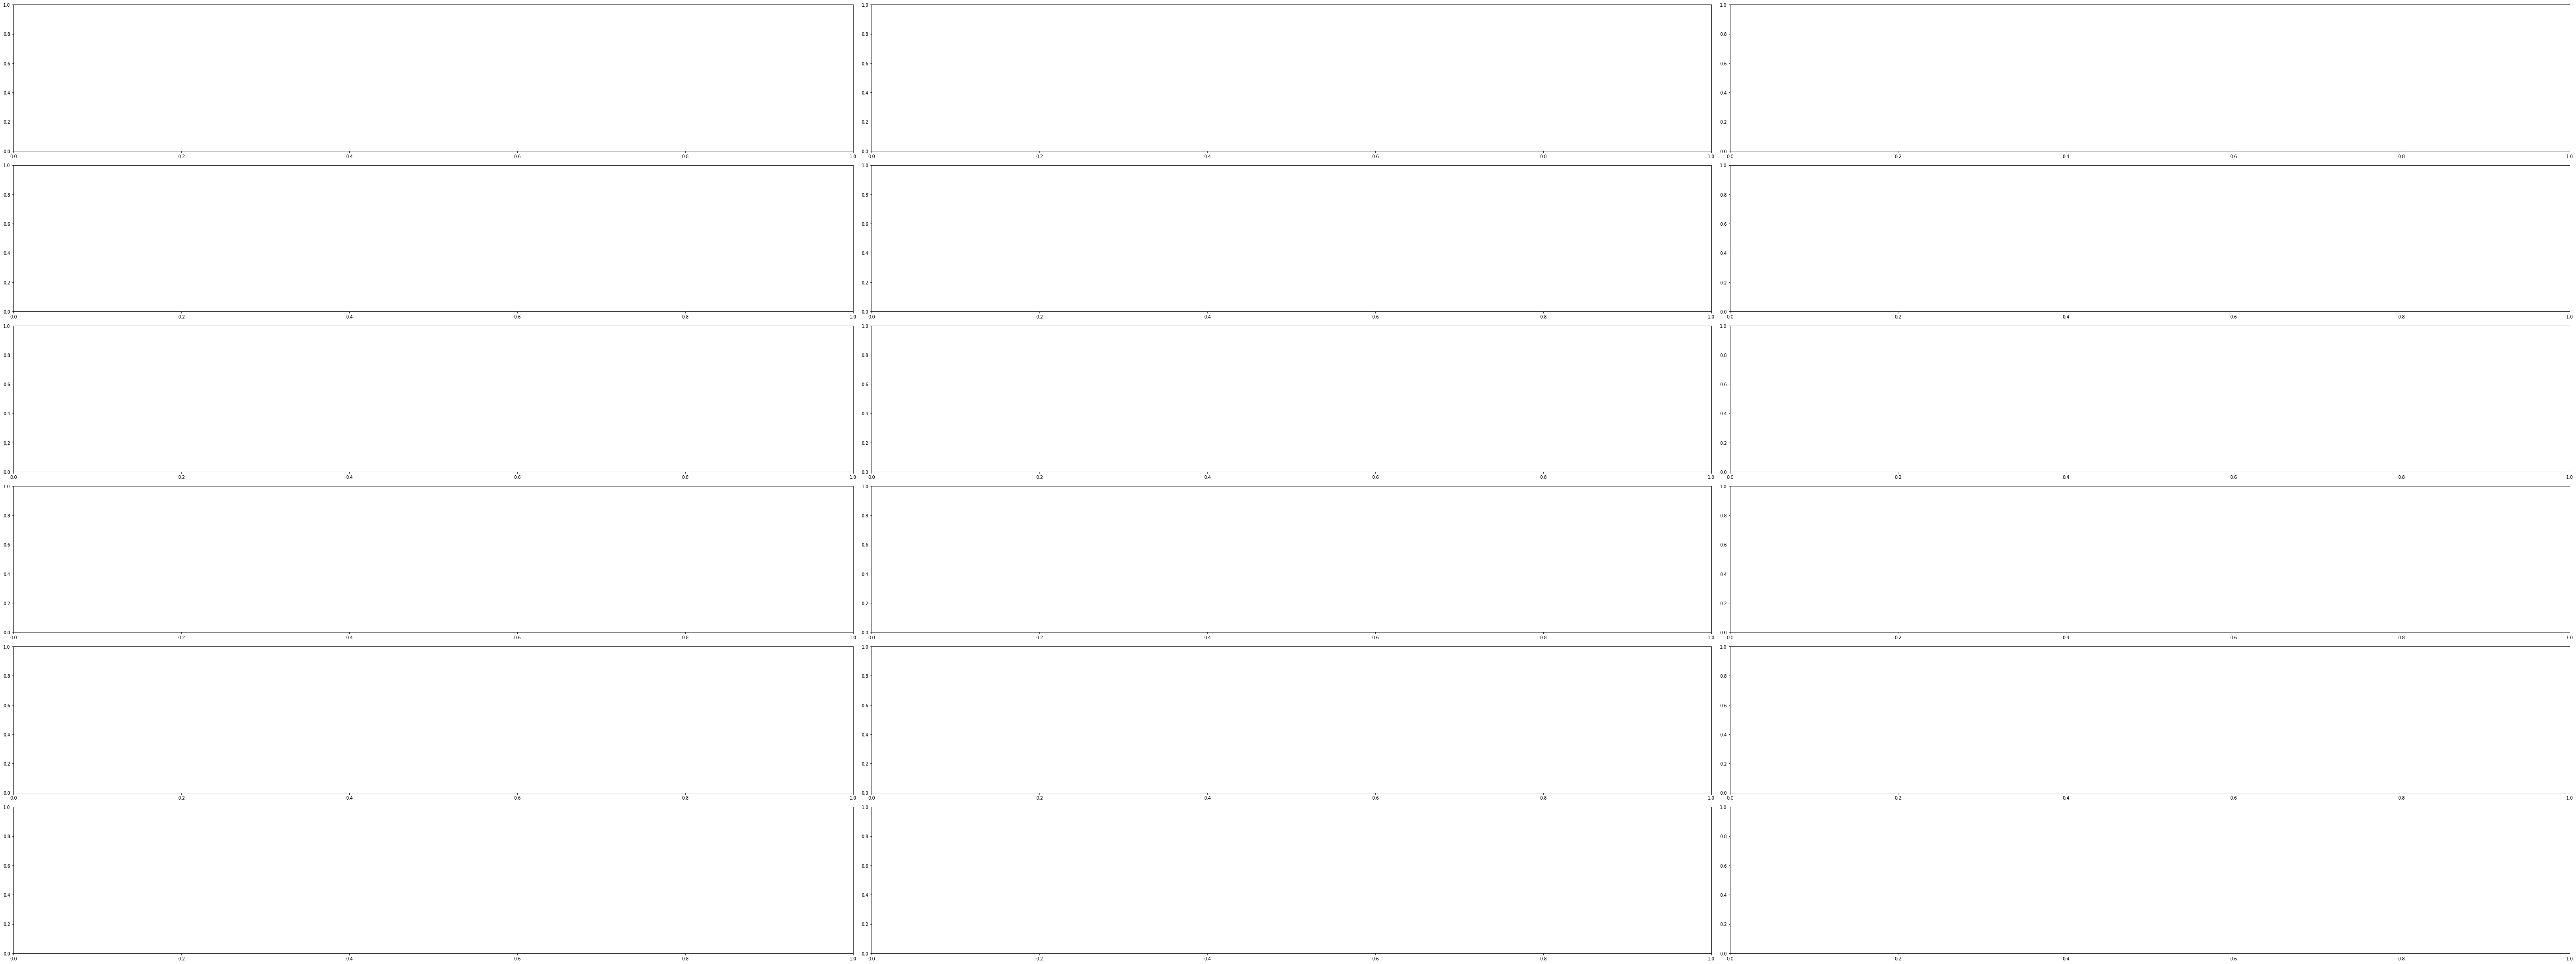

In [59]:
# Visualizing the sample images.
OUTPUT_PATH = 'data/kitti/fusion/faster_rcnn/inference_results_imgs_retrain' # relative path from $USER_EXPERIMENT_DIR.
COLS = 3 # number of columns in the visualizer grid.
IMAGES = 18 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)


 ## 9. Deploy! <a class="anchor" id="head-9"></a>

In [20]:
# Export in FP32 mode.
!if [ -f $USER_EXPERIMENT_DIR/data/kitti/fusion/faster_rcnn/frcnn_kitti_resnet18_retrain.etlt ]; then rm $USER_EXPERIMENT_DIR/data/kitti/fusion/faster_rcnn/frcnn_kitti_resnet18_retrain.etlt; fi
!faster_rcnn export --gpu_index $GPU_INDEX -m $USER_EXPERIMENT_DIR/data/kitti/fusion/faster_rcnn/frcnn_kitti_resnet18_retrain.epoch20.tlt  \
                        -o $USER_EXPERIMENT_DIR/data/kitti/fusion/faster_rcnn/frcnn_kitti_resnet18_retrain.etlt \
                        -e $SPECS_DIR/default_spec_resnet18_retrain_spec_custom.txt \
                        -k $KEY

Using TensorFlow backend.
Using TensorFlow backend.
2021-03-27 15:39:40,169 [INFO] iva.faster_rcnn.spec_loader.spec_loader: Loading experiment spec at ./specs/default_spec_resnet18_retrain_spec_custom.txt.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 3, 400, 400)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 200, 200) 7056        input_image[0][0]                
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 200, 200) 192         conv1[0][0]                      
__________________________________________________________________________________________________
ac

Total params: 5,610,680
Trainable params: 5,449,640
Non-trainable params: 161,040
__________________________________________________________________________________________________
NOTE: UFF has been tested with TensorFlow 1.14.0.
Converting NMS as custom op: NMS_TRT
DEBUG: convert reshape to flatten node
Converting roi_pooling_conv_1/CropAndResize_new as custom op: CropAndResize
Converting proposal as custom op: Proposal
DEBUG [/usr/local/lib/python3.6/dist-packages/uff/converters/tensorflow/converter.py:96] Marking ['NMS'] as outputs


In [ ]:
# Export in FP16 mode.
# Note that the .etlt model in FP16 mode is the same as in FP32 mode.
!if [ -f $USER_EXPERIMENT_DIR/data/faster_rcnn/frcnn_kitti_resnet18_retrain_fp16.etlt ]; then rm $USER_EXPERIMENT_DIR/data/faster_rcnn/frcnn_kitti_resnet18_retrain_fp16.etlt; fi
!faster_rcnn export --gpu_index $GPU_INDEX -m $USER_EXPERIMENT_DIR/data/faster_rcnn/frcnn_kitti_resnet18_retrain.epoch12.tlt  \
                        -o $USER_EXPERIMENT_DIR/data/faster_rcnn/frcnn_kitti_resnet18_retrain_fp16.etlt \
                        -e $SPECS_DIR/default_spec_resnet18_retrain_spec.txt \
                        -k $KEY \
                        --data_type fp16

In [ ]:
# Export in INT8 mode(generate calibration cache file).
# Note that the .etlt model in INT8 mode is the same as in FP32 mode.
!if [ -f $USER_EXPERIMENT_DIR/data/faster_rcnn/frcnn_kitti_resnet18_retrain_int8.etlt ]; then rm $USER_EXPERIMENT_DIR/data/faster_rcnn/frcnn_kitti_resnet18_retrain_int8.etlt; fi
!faster_rcnn export --gpu_index $GPU_INDEX -m $USER_EXPERIMENT_DIR/data/faster_rcnn/frcnn_kitti_resnet18_retrain.epoch12.tlt  \
                        -o $USER_EXPERIMENT_DIR/data/faster_rcnn/frcnn_kitti_resnet18_retrain_int8.etlt \
                        -e $SPECS_DIR/default_spec_resnet18_retrain_spec.txt \
                        -k $KEY \
                        --data_type int8 \
                        --batch_size 8 \
                        --batches 10 \
                        --cal_cache_file $USER_EXPERIMENT_DIR/data/faster_rcnn/cal.bin

In [ ]:
# Converting to TensorRT engine(FP32) is omitted here as this is trivial.
# Convert to TensorRT engine(FP16).
# Make sure your GPU type supports the FP16 data type before running this cell.
!CUDA_VISIBLE_DEVICES=$GPU_INDEX tlt-converter -k $KEY  \
               -d 3,384,1248 \
               -o NMS \
               -e $USER_EXPERIMENT_DIR/data/faster_rcnn/trt.fp16.engine \
               -m 4 \
               -t fp16 \
               -i nchw \
               $USER_EXPERIMENT_DIR/data/faster_rcnn/frcnn_kitti_resnet18_retrain_fp16.etlt

In [ ]:
# Convert to TensorRT engine(INT8).
# Make sure your GPU type supports the INT8 data type before running this cell.
!CUDA_VISIBLE_DEVICES=$GPU_INDEX tlt-converter -k $KEY  \
               -d 3,384,1248 \
               -o NMS \
               -c $USER_EXPERIMENT_DIR/data/faster_rcnn/cal.bin \
               -e $USER_EXPERIMENT_DIR/data/faster_rcnn/trt.int8.engine \
               -b 8 \
               -m 4 \
               -t int8 \
               -i nchw \
               $USER_EXPERIMENT_DIR/data/faster_rcnn/frcnn_kitti_resnet18_retrain_int8.etlt

In [ ]:
print('Exported model and converted TensorRT engine:')
print('------------')
!ls -lht $USER_EXPERIMENT_DIR/data/faster_rcnn

In [ ]:
# Do inference with TensorRT on the generated TensorRT engine
# Please go to $USER_EXPERIMENT_DIR/data/faster_rcnn/inference_results_imgs_retrain to see the visualizations.
# Here we use the INT8 engine for inference, if you want to use FP16 engine instead please
# customize the 'trt_engine' parameter in the spec file below to point to the FP16 engine.
!TRT_LINES=$(grep -n 'trt_inference' $SPECS_DIR/default_spec_resnet18_retrain_spec.txt | cut -d: -f1) && printf '%ds/#//g\n' $(seq $TRT_LINES $((TRT_LINES+4))) | sed -i -f - $SPECS_DIR/default_spec_resnet18_retrain_spec.txt
!faster_rcnn inference --gpu_index $GPU_INDEX -e $SPECS_DIR/default_spec_resnet18_retrain_spec.txt

The `inference` tool produces two outputs. 
The paths to the two outputs are exactly the same as the first `inference` command.

In [ ]:
# Visualizing the sample images from TensorRT inference.
OUTPUT_PATH = 'data/faster_rcnn/inference_results_imgs_retrain' # relative path from $USER_EXPERIMENT_DIR.
COLS = 3 # number of columns in the visualizer grid.
IMAGES = 9 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)

In [ ]:
# Doing evaluation with the generated TensorRT engine
# modify the spec file a little for tensorrt_evaluation configuration
# compare the mAP below with that of `evaluate` with retrained tlt model
!TRT_LINES=$(grep -n 'trt_evaluation' $SPECS_DIR/default_spec_resnet18_retrain_spec.txt | cut -d: -f1) && printf '%ds/#//g\n' $(seq $TRT_LINES $((TRT_LINES+4))) | sed -i -f - $SPECS_DIR/default_spec_resnet18_retrain_spec.txt
# do evaluation with tensorrt engine
!faster_rcnn evaluate --gpu_index $GPU_INDEX -e $SPECS_DIR/default_spec_resnet18_retrain_spec.txt

 ## 10. QAT workflow <a class="anchor" id="head-10"></a>

In this section, we will explore the typical Quantization-Aware Training(QAT) workflow with TLT. QAT workflow is almost the same as non-QAT workflow except for two major differences:
1. set `enable_qat` to `True` in training and retraining spec files to enable the QAT for training/retraining
2. when doing export in INT8 mode, the calibration cache is extracted directly from the QAT .tlt model, so no need to specify any TensorRT INT8 calibration related arguments for `export`

 ### 10.1. Training <a class="anchor" id="head-10.1"></a>

In [44]:
# set enable_qat to True in training spec file to enable QAT training
!sed -i 's/enable_qat: False/enable_qat: True/' $SPECS_DIR/default_spec_resnet18_custom.txt
!cat $SPECS_DIR/default_spec_resnet18_custom.txt

# Copyright (c) 2017-2020, NVIDIA CORPORATION.  All rights reserved.
random_seed: 42
enc_key: 'cmV1b2gzMjJnNjRpbGc2Yms0dGIwZmtwdmw6YmE1ZGJkN2YtNzZkMC00OGE0LWE1N2ItNzc2Y2VjMGYwZDk0'
verbose: True
model_config {
input_image_config {
image_type: RGB
image_channel_order: 'bgr'
size_height_width {
height: 384
width: 1248
}
    image_channel_mean {
        key: 'b'
        value: 103.939
}
    image_channel_mean {
        key: 'g'
        value: 116.779
}
    image_channel_mean {
        key: 'r'
        value: 123.68
}
image_scaling_factor: 1.0
max_objects_num_per_image: 100
}
arch: "resnet:18"
anchor_box_config {
scale: 64.0
scale: 128.0
scale: 256.0
ratio: 1.0
ratio: 0.5
ratio: 2.0
}
freeze_bn: True
freeze_blocks: 0
freeze_blocks: 1
roi_mini_batch: 256
rpn_stride: 16
use_bias: False
roi_pooling_config {
pool_size: 7
pool_size_2x: False
}
all_projections: True
use_pooling:False
}
dataset_config {
  data_sources: {
    tfrecords_path: "/workspace/tlt-experiments/tfrecords/kitti_trainval/kit

In [46]:
# run QAT training
!faster_rcnn train --gpu_index $GPU_INDEX -e $SPECS_DIR/default_spec_resnet18_custom.txt

Using TensorFlow backend.
Using TensorFlow backend.

2021-03-20 14:47:31,514 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/horovod/tensorflow/__init__.py:117: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.


2021-03-20 14:47:31,514 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/horovod/tensorflow/__init__.py:143: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.


2021-03-20 14:47:31,573 [WARNING] tensorflow: From /home/vpraveen/.cache/dazel/_dazel_vpraveen/216c8b41e526c3295d3b802489ac2034/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/faster_rcnn/scripts/train.py:47: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


2021-03-20 14:47:31,573 [WARNING] tensorflow: From /home/vpraveen/.cache/dazel/_dazel_vpraveen/216c8b41e526c3295d3b802489ac2034/execroot/ai_infra/bazel-out


2021-03-20 14:47:33,275 [WARNING] tensorflow: From /home/vpraveen/.cache/dazel/_dazel_vpraveen/216c8b41e526c3295d3b802489ac2034/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/faster_rcnn/layers/utils.py:76: The name tf.debugging.assert_less is deprecated. Please use tf.compat.v1.debugging.assert_less instead.


2021-03-20 14:47:33,460 [WARNING] tensorflow: From /home/vpraveen/.cache/dazel/_dazel_vpraveen/216c8b41e526c3295d3b802489ac2034/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/faster_rcnn/layers/utils.py:382: The name tf.random_shuffle is deprecated. Please use tf.random.shuffle instead.


2021-03-20 14:47:33,702 [WARNING] tensorflow: From /home/vpraveen/.cache/dazel/_dazel_vpraveen/216c8b41e526c3295d3b802489ac2034/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/faster_rcnn/layers/utils.py:255: The name tf.log is deprecated. P


2021-03-20 14:48:29,199 [WARNING] tensorflow: From /home/vpraveen/.cache/dazel/_dazel_vpraveen/216c8b41e526c3295d3b802489ac2034/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/faster_rcnn/layers/utils.py:64: The name tf.unsorted_segment_min is deprecated. Please use tf.math.unsorted_segment_min instead.

2021-03-20 14:48:30,338 [INFO] __main__: Building validation dataset...
2021-03-20 14:48:31,035 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Serial augmentation enabled = False
2021-03-20 14:48:31,035 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Pseudo sharding enabled = False
2021-03-20 14:48:31,036 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Max Image Dimensions (all sources): (0, 0)
2021-03-20 14:48:31,036 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: number of cpus: 12, io threads: 24, compute threads: 12, buffered batches: 4
2021-03-20 14:


2021-03-20 14:52:06,277 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.


2021-03-20 14:52:06,432 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

Epoch 1/12
  2/861 [..............................] - ETA: 1:09:45 - loss: 1.6774 - rpn_out_class_loss: 0.6725 - rpn_out_regress_loss: 0.0486 - dense_class_td_loss: 0.3890 - dense_regress_td_loss: 0.1066 - dense_class_td_acc: 0.8887/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.343660). Check your callbacks.
  % delta_t_median)
861/861 [==============================] - 93s 108ms/step - loss: 0.8156 - rpn_out_class_loss: 0.0322 - rpn_out_regress_loss: 0.0141 - dense_class_td_loss: 0

 ### 10.2. Evaluation <a class="anchor" id="head-10.2"></a>

In [ ]:
!faster_rcnn evaluate --gpu_index $GPU_INDEX -e $SPECS_DIR/default_spec_resnet18.txt

 ### 10.3. Pruning <a class="anchor" id="head-10.3"></a>

In [ ]:
!faster_rcnn prune --gpu_index $GPU_INDEX -m $USER_EXPERIMENT_DIR/data/faster_rcnn/frcnn_kitti_resnet18.epoch12.tlt \
           -o $USER_EXPERIMENT_DIR/data/faster_rcnn/model_1_pruned.tlt  \
           -eq union  \
           -pth 0.2 \
           -k $KEY

 ### 10.4. Retraining <a class="anchor" id="head-10.4"></a>

In [ ]:
# set enable_qat to True in retraining spec file to enable QAT
!sed -i 's/enable_qat: False/enable_qat: True/' $SPECS_DIR/default_spec_resnet18_retrain_spec.txt
!cat $SPECS_DIR/default_spec_resnet18_retrain_spec.txt

In [ ]:
!faster_rcnn train --gpu_index $GPU_INDEX -e $SPECS_DIR/default_spec_resnet18_retrain_spec.txt

 ### 10.5. Evaluation of the retrained model <a class="anchor" id="head-10.5"></a>

In [ ]:
# disable the tensorrt evaluation config in spec file
!TRT_LINES=$(grep -n 'trt_evaluation' $SPECS_DIR/default_spec_resnet18_retrain_spec.txt | cut -d: -f1) && printf '%ds/^/#/g\n' $(seq $TRT_LINES $((TRT_LINES+4))) | sed -i -f - $SPECS_DIR/default_spec_resnet18_retrain_spec.txt

In [ ]:
# do evaluation with .tlt model
!faster_rcnn evaluate --gpu_index $GPU_INDEX -e $SPECS_DIR/default_spec_resnet18_retrain_spec.txt

 ### 10.6. Inference of the retrained model <a class="anchor" id="head-10.6"></a>

In [ ]:
# disable the tensorrt inference config in spec file
!TRT_LINES=$(grep -n 'trt_inference' $SPECS_DIR/default_spec_resnet18_retrain_spec.txt | cut -d: -f1) && printf '%ds/^/#/g\n' $(seq $TRT_LINES $((TRT_LINES+4))) | sed -i -f - $SPECS_DIR/default_spec_resnet18_retrain_spec.txt

In [ ]:
# do inference with .tlt model
!faster_rcnn inference --gpu_index $GPU_INDEX -e $SPECS_DIR/default_spec_resnet18_retrain_spec.txt

In [ ]:
# Visualizing the sample images
OUTPUT_PATH = 'data/faster_rcnn/inference_results_imgs_retrain' # relative path from $USER_EXPERIMENT_DIR.
COLS = 3 # number of columns in the visualizer grid.
IMAGES = 9 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)

 ### 10.7. Deployment of the QAT model <a class="anchor" id="head-10.7"></a>

In [ ]:
# Export in INT8 mode(generate calibration cache file).
# No need for calibration dataset for QAT model INT8 export
!rm $USER_EXPERIMENT_DIR/data/faster_rcnn/cal.bin
!if [ -f $USER_EXPERIMENT_DIR/data/faster_rcnn/frcnn_kitti_resnet18_retrain_int8_qat.etlt ]; then rm $USER_EXPERIMENT_DIR/data/faster_rcnn/frcnn_kitti_resnet18_retrain_int8_qat.etlt; fi
!faster_rcnn export --gpu_index $GPU_INDEX -m $USER_EXPERIMENT_DIR/data/faster_rcnn/frcnn_kitti_resnet18_retrain.epoch12.tlt  \
                        -o $USER_EXPERIMENT_DIR/data/faster_rcnn/frcnn_kitti_resnet18_retrain_int8_qat.etlt \
                        -e $SPECS_DIR/default_spec_resnet18_retrain_spec.txt \
                        -k $KEY \
                        --data_type int8 \
                        --cal_cache_file $USER_EXPERIMENT_DIR/data/faster_rcnn/cal.bin

In [ ]:
# Convert to TensorRT engine(INT8).
# Make sure your GPU type supports the INT8 data type before running this cell.
!CUDA_VISIBLE_DEVICES=$GPU_INDEX tlt-converter -k $KEY  \
               -d 3,384,1248 \
               -o NMS \
               -c $USER_EXPERIMENT_DIR/data/faster_rcnn/cal.bin \
               -e $USER_EXPERIMENT_DIR/data/faster_rcnn/trt.int8.engine \
               -b 8 \
               -m 4 \
               -t int8 \
               -i nchw \
               $USER_EXPERIMENT_DIR/data/faster_rcnn/frcnn_kitti_resnet18_retrain_int8_qat.etlt

In [ ]:
print('Exported model and converted TensorRT engine:')
print('------------')
!ls -lht $USER_EXPERIMENT_DIR/data/faster_rcnn

In [ ]:
# Do inference with TensorRT on the generated TensorRT engine
# Please go to $USER_EXPERIMENT_DIR/data/faster_rcnn/inference_results_imgs_retrain to see the visualizations.
!TRT_LINES=$(grep -n 'trt_inference' $SPECS_DIR/default_spec_resnet18_retrain_spec.txt | cut -d: -f1) && printf '%ds/#//g\n' $(seq $TRT_LINES $((TRT_LINES+4))) | sed -i -f - $SPECS_DIR/default_spec_resnet18_retrain_spec.txt
!faster_rcnn inference --gpu_index $GPU_INDEX -e $SPECS_DIR/default_spec_resnet18_retrain_spec.txt

In [ ]:
# Visualizing the sample images from TensorRT inference.
OUTPUT_PATH = 'data/faster_rcnn/inference_results_imgs_retrain' # relative path from $USER_EXPERIMENT_DIR.
COLS = 3 # number of columns in the visualizer grid.
IMAGES = 9 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)

In [ ]:
# Doing evaluation with the generated TensorRT engine
# compare the mAP below with that of `evaluate` with retrained tlt model
!TRT_LINES=$(grep -n 'trt_evaluation' $SPECS_DIR/default_spec_resnet18_retrain_spec.txt | cut -d: -f1) && printf '%ds/#//g\n' $(seq $TRT_LINES $((TRT_LINES+4))) | sed -i -f - $SPECS_DIR/default_spec_resnet18_retrain_spec.txt
!faster_rcnn evaluate --gpu_index $GPU_INDEX -e $SPECS_DIR/default_spec_resnet18_retrain_spec.txt